In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import pickle
from df_utils import * 


In [32]:
# Just change this parameter to get the plots for each run 
run = "run3"

# Change to  your own paths accordingly 

# Path to where the pickle files are stored 
samples_dir = "E:/score/" + run + "_det_vars/"

# Path to where you want to store your plots 
fig_dir = "E:/result/multisim_var/"

df = pd.read_pickle(samples_dir + run + "_NuMI_CV_high_stats_score.pkl")
df = filter_df(df)
df = Edit_Weight_Tune(df)
MC_weight_branch(df)
weight_PPFX=df.iloc[:,8]
weight_GENIE=df.iloc[:,9]
weight_Reint=df.iloc[:,10]
cv=df.iloc[:,13]

cv=logit_transform(cv)
PPFX=np.array(weight_PPFX)/1000
GENIE=np.array(weight_GENIE)/1000
Reint=np.array(weight_Reint)/1000

In [33]:
# General settings:
n_x_bins = 8
n_y_bins = 30
y_up = 0. 


if(run=='run1'):
    y_up = 90.
    binning=[0., 0.55053561, 1.10107123, 1.65160684, 2.20214245, 2.75267806, 3.30321368, 4.95482051]
else:
    y_up = 240.
    binning=[0.0, 0.5677753041587242, 1.1355506083174485, 1.7033259124761728, 2.271101216634897, 2.838876520793621, 3.4066518249523456, 5.109977737428518]

multisim_range = np.array(([(0., binning[-1]), (0., y_up)]))


xy_binning = (binning, n_y_bins)
x_binning = binning

cmin_treshold = 1e-10

# This is in case we need to add the POT scaling 
Norm = 1.0 

# List to store error histograms 

error_hists = []

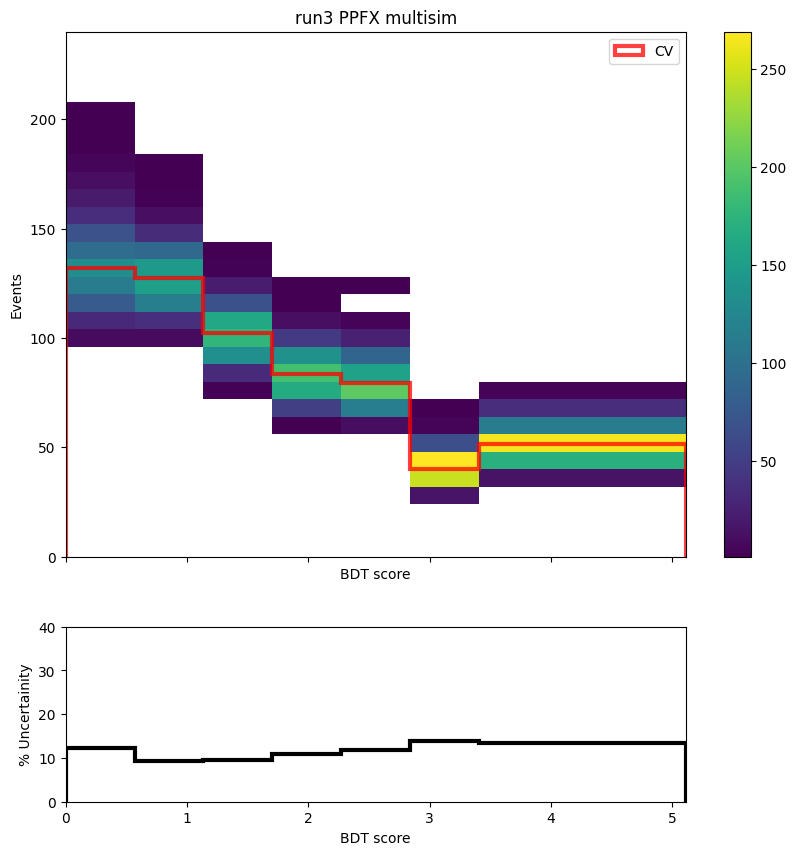

In [34]:
NUniverses = 600

n_tot = np.empty([NUniverses,len(binning) -1])
n_cv_tot = np.empty([len(binning) - 1])
n_tot.fill(0)
n_cv_tot.fill(0)

spline_fix_cv  = df["weight"]*Norm
spline_fix_var = df["weight"]*Norm



fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,10])
plt.sca(ax[0])
plt.xlabel('BDT score')
plt.ylabel(r'Events')
plt.title(run + ' PPFX multisim')
(counts_std, bins_std) = np.histogram(cv, weights=df['weight'], bins=x_binning)

n_cv_tot += counts_std 

i=0
x=[]
y=[]


while i < NUniverses:
    weight=[]
    PPFX_w=[]
    for we in PPFX:
        weight.append(we[i])
    weight = pd.DataFrame(weight)
    weight = weight.iloc[:,0].values
    weight[weight == 1]= df["ppfx_cv"].iloc[weight == 1]
    weight[np.isnan(weight)] = df["ppfx_cv"].iloc[np.isnan(weight)]
    weight[weight > 100] = df["ppfx_cv"].iloc[weight > 100]
    weight[weight < 0] = df["ppfx_cv"].iloc[weight < 0]
    weight[weight == np.inf] = df["ppfx_cv"].iloc[weight == np.inf]
    PPFX_w=(weight)
    (counts_we, bins_we) = np.histogram(cv, weights=PPFX_w*np.nan_to_num(spline_fix_var/df["ppfx_cv"]), bins=x_binning)
    n_tot[i] = counts_we 
    x.append(bins_we[:-1])
    y.append(counts_we)
    i=i+1
    

cov = np.empty([len(counts_std), len(counts_std)])
cov.fill(0)    
for n in n_tot:
    for i in range(len(counts_std)):
        for j in range(len(counts_std)):
            cov[i][j] += (n[i] - n_cv_tot[i])*(n[j] - n_cv_tot[j])
            
cov /= NUniverses

    
x=np.array(x)
ana_x=x.flatten()
ana_x=ana_x.tolist()
y=np.array(y)
ana_y=y.flatten()
ana_y=ana_y.tolist()  
plt.hist2d(ana_x,ana_y,bins=xy_binning, range=multisim_range, cmin=cmin_treshold)
plt.hist(bins_std[:-1], bins_std, weights=counts_std, alpha=0.75, histtype='step',label='CV',color='r',lw=3)
cb = plt.colorbar()
plt.xlim(0.,binning[-1])
plt.ylim(0.,y_up)
plt.legend()

plt.sca(ax[1])
pos = ax[0].get_position()
pos2 = ax[1].get_position()
ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])

plt.hist(bins_std[:-1],bins_std,weights=np.sqrt(np.diag(cov))/n_cv_tot*100, color = "black", histtype="step",lw=3,linestyle="-")
error_hists.append((bins_std,np.sqrt(np.diag(cov))/n_cv_tot*100))
plt.ylabel("% Uncertainity")
plt.xlabel("BDT score")
plt.ylim(0,40)
plt.xlim(0.,binning[-1])
plt.savefig(fig_dir + run + "_PPFX_uncertainty.png") 

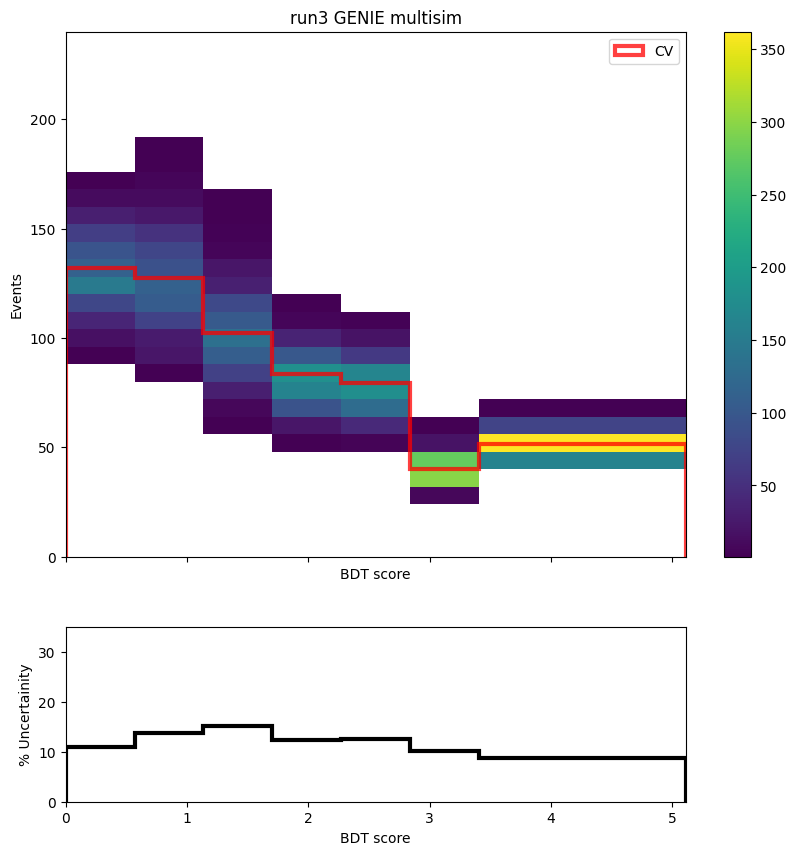

In [35]:
NUniverses = 600

n_tot = np.empty([NUniverses,len(binning)-1])
n_cv_tot = np.empty([len(binning) -1])
n_tot.fill(0)
n_cv_tot.fill(0)



fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,10])
plt.sca(ax[0])
plt.xlabel('BDT score')
plt.ylabel(r'Events')
plt.title(run + ' GENIE multisim')
(counts_std, bins_std) = np.histogram(cv, weights = df['weight'], bins=x_binning)

n_cv_tot += counts_std 

i=0
x=[]
y=[]


while i < NUniverses:
    weight=[]
    genie_w=[]
    for we in GENIE:
        weight.append(we[i])
    weight = pd.DataFrame(weight)
    weight = weight.iloc[:,0].values
    weight[weight == 1]= df["weightSplineTimesTune"].iloc[weight == 1]
    weight[np.isnan(weight)] = df["weightSplineTimesTune"].iloc[np.isnan(weight)]
    weight[weight > 50] = df["weightSplineTimesTune"].iloc[weight > 50] # why 30 not 50?
    weight[weight <= 0] = df["weightSplineTimesTune"].iloc[weight <= 0]
    weight[weight == np.inf] = df["weightSplineTimesTune"].iloc[weight == np.inf]
    genie_w=(weight)
    (counts_we, bins_we) = np.histogram(cv, weights=genie_w*spline_fix_var/df["weightSplineTimesTune"], bins=x_binning)
    n_tot[i] = counts_we 
    x.append(bins_we[:-1])
    y.append(counts_we)
    i=i+1
    

cov = np.empty([len(counts_std), len(counts_std)])
cov.fill(0)    
for n in n_tot:
    for i in range(len(counts_std)):
        for j in range(len(counts_std)):
            cov[i][j] += (n[i] - n_cv_tot[i])*(n[j] - n_cv_tot[j])
            
cov /= NUniverses

    
x=np.array(x)
ana_x=x.flatten()
ana_x=ana_x.tolist()
y=np.array(y)
ana_y=y.flatten()
ana_y=ana_y.tolist()  
plt.hist2d(ana_x,ana_y,bins=xy_binning,range=multisim_range,cmin=cmin_treshold)
plt.hist(bins_std[:-1], bins_std, weights=counts_std ,alpha=0.75, histtype='step',label='CV',color='r',lw=3)
cb = plt.colorbar()
plt.xlim(0.,binning[-1])
plt.ylim(0.,y_up)
plt.legend()

plt.sca(ax[1])
pos = ax[0].get_position()
pos2 = ax[1].get_position()
ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
plt.hist(bins_std[:-1],bins_std,weights=np.sqrt(np.diag(cov))/n_cv_tot*100, color = "black", histtype="step",lw=3,linestyle="-")
error_hists.append((bins_std,np.sqrt(np.diag(cov))/n_cv_tot*100))
plt.ylabel("% Uncertainity")
plt.xlabel("BDT score")
plt.ylim(0,35.)
plt.xlim(0.,binning[-1])
plt.savefig(fig_dir + run + "_GENIE_uncertainty.png")

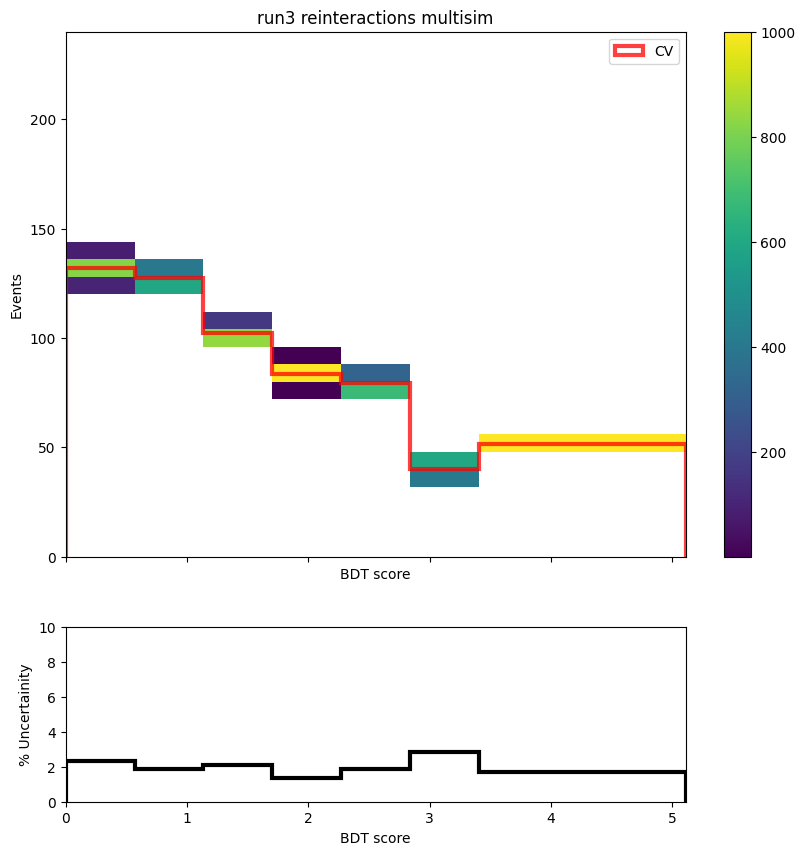

In [36]:
NUniverses = 1000

n_tot = np.empty([NUniverses,len(binning)-1])
n_cv_tot = np.empty([len(binning)-1])
n_tot.fill(0)
n_cv_tot.fill(0)



fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,10])
plt.sca(ax[0])
plt.xlabel('BDT score')
plt.ylabel(r'Events')
plt.title(run + ' reinteractions multisim')
(counts_std, bins_std) = np.histogram(cv, weights = df['weight'], bins=x_binning)

n_cv_tot += counts_std 

i=0
x=[]
y=[]


while i < NUniverses:
    weight=[]
    reint_w=[]
    for we in Reint:
        weight.append(we[i])
    weight = pd.DataFrame(weight)
    weight = weight.iloc[:,0].values
    weight[np.isnan(weight)] = 1
    weight[weight > 100] = 1
    weight[weight < 0] = 1
    weight[weight == np.inf] = 1
    reint_w=(weight)
    (counts_we, bins_we) = np.histogram(cv, weights=reint_w*spline_fix_var, bins=x_binning)
    n_tot[i] = counts_we 
    x.append(bins_we[:-1])
    y.append(counts_we)
    i=i+1
    

cov = np.empty([len(counts_std), len(counts_std)])
cov.fill(0)    
for n in n_tot:
    for i in range(len(counts_std)):
        for j in range(len(counts_std)):
            cov[i][j] += (n[i] - n_cv_tot[i])*(n[j] - n_cv_tot[j])
            
cov /= NUniverses

    
x=np.array(x)
ana_x=x.flatten()
ana_x=ana_x.tolist()
y=np.array(y)
ana_y=y.flatten()
ana_y=ana_y.tolist()  
plt.hist2d(ana_x,ana_y,bins=xy_binning,range=multisim_range,cmin=cmin_treshold)
plt.hist(bins_std[:-1], bins_std, weights=counts_std ,alpha=0.75, histtype='step',label='CV',color='r',lw=3)
cb = plt.colorbar()
plt.xlim(0.,binning[-1])
plt.ylim(0.,y_up)
plt.legend()

plt.sca(ax[1])
pos = ax[0].get_position()
pos2 = ax[1].get_position()
ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
plt.hist(bins_std[:-1],bins_std,weights=np.sqrt(np.diag(cov))/n_cv_tot*100, color = "black", histtype="step",lw=3,linestyle="-")
error_hists.append((bins_std,np.sqrt(np.diag(cov))/n_cv_tot*100))
plt.ylabel("% Uncertainity")
plt.xlabel("BDT score")
plt.ylim(0,10.)
plt.xlim(0.,binning[-1])
plt.savefig(fig_dir + run + "_reint_uncertainty.png")

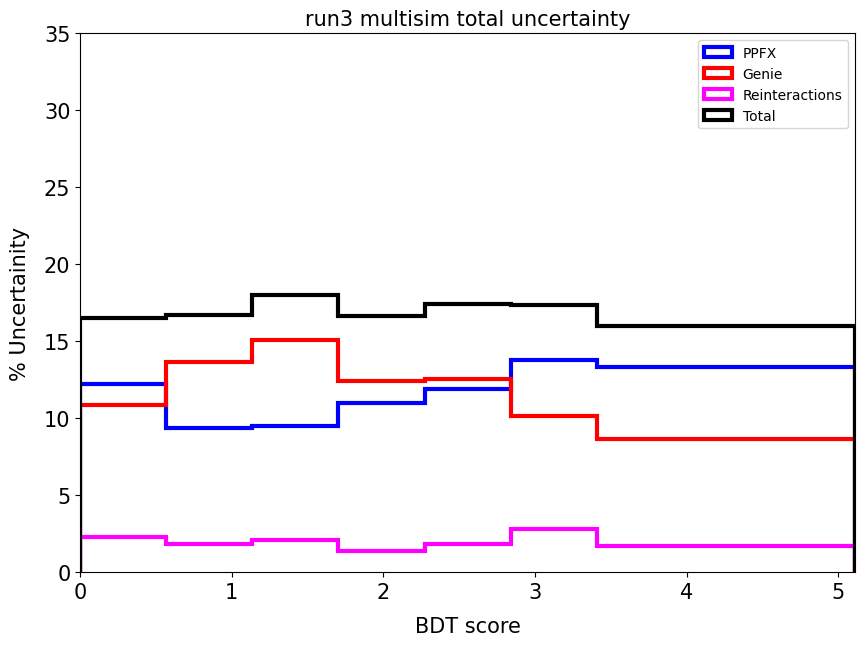

In [44]:
plt.figure(figsize=(10,7))
#det_err=[50,50,50,50,50,50,50]
#det_err=np.array(det_err)+det_err**2
total_err=np.sqrt((error_hists[0][1])**2+(error_hists[1][1])**2+(error_hists[2][1])**2)
    
plt.hist(bins_std[:-1],bins_std,weights=error_hists[0][1], color = "blue",label='PPFX', histtype="step",lw=3,linestyle="-")
plt.hist(bins_std[:-1],bins_std,weights=error_hists[1][1], color = "red",label='Genie', histtype="step",lw=3,linestyle="-")
#plt.hist(bins_std[:-1],bins_std,weights=det_err, color = "green",label='detector', histtype="step",lw=3,linestyle="-")
plt.hist(bins_std[:-1],bins_std,weights=error_hists[2][1], color = "magenta",label='Reinteractions', histtype="step",lw=3,linestyle="-")
plt.hist(bins_std[:-1],bins_std,weights=total_err, color = "black",label='Total', histtype="step",lw=3,linestyle="-")
plt.legend(fontsize=10)
plt.ylim(0.,35.)
plt.xlim(0.,binning[-1])
plt.xticks(size=15)
plt.yticks(size=15)
plt.title(run + ' multisim total uncertainty',fontsize=15)
plt.ylabel("% Uncertainity",fontsize=15,labelpad=10)
plt.xlabel("BDT score", fontsize=15, labelpad=10)
plt.savefig(fig_dir + run + "_multisim_errors.png")